In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_wine
np.random.seed(12345) # Set initial random seed

In [ ]:
def activate(a, f="none"):

    if f=="none":
        y = a
    elif f == "relu":
        y = np.maximum(a,0)
    elif f == "sigmoid":
        y = 0.5 * (np.tanh(a/2) + 1)
    elif f == "softmax":
        a = a - np.max(a, axis=1, keepdims=True)
        exp_a = np.exp(a)
        y = exp_a / np.sum(exp_a, axis=1, keepdims=True)
    return y

def d_activate(a, f="none"):
    # Derivatives of activation functions
    if f=="none":
        dy = np.ones_like(a)
    elif f == "relu":
        dy = 1 * (a > 0)
    elif f == "sigmoid":
        s = 0.5 * (np.tanh(a/2) + 1)
        dy = s * (1 - s)
    elif f == "softmax":
        a = a - np.max(a, axis=1, keepdims=True)
        exp_a = np.exp(a)
        s = exp_a / np.sum(exp_a, axis=1, keepdims=True)
        dy = np.diag(s) - np.outer(s, s.T)
    return dy

def train_test_split(X, y, test_size=0.2):
    shuffle_idx = np.random.permutation(len(X))
    test_idx = int(len(X) * test_size)
    X_train = X[shuffle_idx[test_idx:]]
    y_train = y[shuffle_idx[test_idx:]]
    X_test = X[shuffle_idx[:test_idx]]
    y_test = y[shuffle_idx[:test_idx]]
    return X_train, X_test, y_train, y_test

def shuffle_and_batch_data(data, data_target, batch_size):
    idx = np.random.permutation(data.shape[0])
    shuffled_data = data[idx]
    shuffled_data_target = data_target[idx]
    num_batches = data.shape[0] // batch_size
    data_batches = np.array_split(shuffled_data, num_batches)
    target_batches = np.array_split(shuffled_data_target, num_batches)
    return data_batches, target_batches, num_batches

In [ ]:
class NeuralNetwork():

    def __init__(self, train_data, test_data, n_input, n_output, n_hidden):
        self.train_data = train_data
        self.test_data = test_data
        self.n_output = n_output
        self.vwb, self.wb = self._init_param(
            n_input, n_hidden, n_output
        )
        self.activations = ["sigmoid"] * len(n_hidden) + ["softmax"]
        self.losses = []

    def _init_param(self, n_input, n_hidden, n_output):
        l = len(n_hidden)
        vwb, wb = {}, {}

        wb["W1"] = np.random.randn(n_input, n_hidden[0])
        wb["b1"] = np.zeros((1, n_hidden[0]))

        for i in range(1, l):
            wb[f"W{i+1}"] = np.random.randn(n_hidden[i-1], n_hidden[i])
            wb[f"b{i+1}"] = np.zeros((1, n_hidden[i]))
            vwb[f"vW{i}"], vwb[f"vb{i}"] = 0, 0
            vwb[f"vW{i+1}"], vwb[f"vb{i+1}"] = 0, 0

        wb[f"W{l+1}"] = np.random.randn(n_hidden[-1], n_output)
        wb[f"b{l+1}"] = np.zeros((1, n_output))
        vwb[f"vW{l+1}"], vwb[f"vb{l+1}"] = 0, 0

        return vwb, wb

    def _compute_loss_and_propagation(self, n_output, data_batches, target_batches, wb, f):
        # Forward propagation
        y_hat, fp = self._forward_propagation(data_batches, wb, f)

        # Convert target labels to one-hot encoded matrix
        y = np.zeros((target_batches.shape[0], n_output))
        y[np.arange(target_batches.shape[0]), target_batches] = 1

        # Compute loss
        loss = self._cross_entropy_loss(y, y_hat)

        # Backward propagation
        bp = self._backpropagation(y, y_hat, data_batches, wb, fp, f)

        return loss, fp, bp

    def _forward_propagation(self, data_batches, wb, f):
        l = len(wb)
        fp = {}
        fp["z1"] = np.dot(data_batches, wb["W1"]) + wb["b1"]

        for i in range(1, int(l/2)):
            fp[f"a{i}"] = activate(fp[f"z{i}"], f[i-1])
            fp[f"z{i+1}"] = np.dot(fp[f"a{i}"], wb[f"W{i+1}"]) + wb[f"b{i+1}"]

        y_hat = activate(fp[f"z{int(l/2)}"], f[-1])

        return y_hat, fp

    def _backpropagation(self, y, y_hat, data_batches, wb, fp, f):
        l = int(np.floor(len(fp)/2))
        bp = {}

        dL_dy_hat = (y_hat - y) / y.shape[0]
        bp[f"dL_dz{l+1}"] = dL_dy_hat * d_activate(fp[f"z{l+1}"], f[-2])

        for i in reversed(range(l)):
            bp[f"dL_da{i+1}"] = np.dot(bp[f"dL_dz{i+2}"], wb[f"W{i+2}"].T)
            bp[f"dL_dz{i+1}"] = bp[f"dL_da{i+1}"] * d_activate(fp[f"z{i+1}"], f[i])

        for i in reversed(range(l)):
            bp[f"dL_dW{i+2}"] = np.dot(np.transpose(fp[f"a{i+1}"]), bp[f"dL_dz{i+2}"])
            bp[f"dL_db{i+2}"] = np.sum(bp[f"dL_dz{i+2}"], axis=0, keepdims=True)

        bp[f"dL_dW1"] = np.dot(np.transpose(data_batches), bp[f"dL_dz1"])
        bp[f"dL_db1"] = np.sum(bp[f"dL_dz1"], axis=0, keepdims=True)

        return bp

    def _cross_entropy_loss(self, y, y_hat):
        # Compute the cross-entropy loss
        eps = 1e-8
        y_hat = np.clip(y_hat, eps, 1 - eps)
        loss = -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
        return loss

    def _update_weights_and_biases (self, grad, mf, lr):
        l = int(np.floor(len(self.wb)/2))
        for i in range(1, l+1):
            self.vwb[f"vW{i}"] = mf * self.vwb[f"vW{i}"] + (1 - mf) * grad[f"dL_dW{i}"]
            self.vwb[f"vb{i}"] = mf * self.vwb[f"vb{i}"] + (1 - mf) * grad[f"dL_db{i}"]
            self.wb[f"W{i}"] -= lr * self.vwb[f"vW{i}"]
            self.wb[f"b{i}"] -= lr * self.vwb[f"vb{i}"]

    def train(self, num_epochs=50, batch_size=32, mf=0.9 ,lr=0.001):
        # Train the neural network
        for i in range(num_epochs):

            loss_total = 0
            data_batches, target_batches, num_batches = shuffle_and_batch_data(
                self.train_data.data,
                self.train_data.target,
                batch_size
            )

            for j in range(num_batches):

                loss, self.fp, self.bp = self._compute_loss_and_propagation(
                    self.n_output, data_batches[j], target_batches[j], self.wb, self.activations
                )
                # Update total loss
                loss_total += loss

                # Update weights and biases using p optimizer
                self._update_weights_and_biases(self.bp, mf, lr)

            # Print the loss every 100 epochs
            if i % 100 == 0:
                print(f"Epoch {i}, loss: {loss:.4f}")

            # Store the loss value
            self.losses.append(loss)

        # Print the average loss for the last epoch
        avg_loss = loss_total / num_batches
        print(f"Epoch {i+1}: average loss = {avg_loss}")

        # Plot the loss
        plt.plot(self.losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

    def evaluate(self):
        l = int(np.floor(len(self.wb)/2))

        # Evaluate the trained model on test data
        self.fp["z1"] = np.dot(self.test_data.data, self.wb["W1"]) + self.wb["b1"]

        for i in range(1, l):
            self.fp[f"a{i}"] = activate(self.fp[f"z{i}"], self.activations[i-1])
            self.fp[f"z{i+1}"] = np.dot(self.fp[f"a{i}"], self.wb[f"W{i+1}"]) + self.wb[f"b{i+1}"]

        y_hat = activate(self.fp[f"z{l}"], self.activations[-1])
        predictions = np.argmax(y_hat, axis=1)
        accuracy = np.mean(predictions == self.test_data.target)
        print(f"Test Accuracy: {accuracy:.4f}")

# Iris Dataset

<div style="border-radius:5px;background-color:#333333;padding:25px;color:#FFFFFF">Just testing out something new.</div>

learning_rate = 0.01, epochs=2000, hidden_ly=[256, 128, 64, 32, 16], batch=32, momentum=0.5
Epoch 0, loss: 1.5630
Epoch 100, loss: 0.4413
Epoch 200, loss: 0.2662
Epoch 300, loss: 0.2878
Epoch 400, loss: 0.2626
Epoch 500, loss: 0.1782
Epoch 600, loss: 0.1736
Epoch 700, loss: 0.1651
Epoch 800, loss: 0.1372
Epoch 900, loss: 0.1188
Epoch 1000, loss: 0.1590
Epoch 1100, loss: 0.1130
Epoch 1200, loss: 0.1149
Epoch 1300, loss: 0.1266
Epoch 1400, loss: 0.1136
Epoch 1500, loss: 0.0900
Epoch 1600, loss: 0.1036
Epoch 1700, loss: 0.0988
Epoch 1800, loss: 0.0808
Epoch 1900, loss: 0.0804
Epoch 2000: average loss = 0.08399786005006264


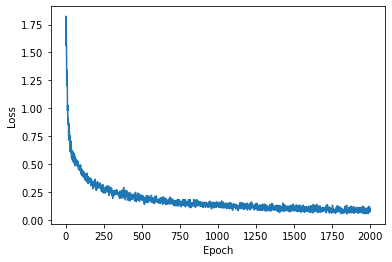

Test Accuracy: 1.0000


In [ ]:
iris = load_iris()
n_input = iris.data.shape[1]
n_output = 3
# Iris Hyperparameters 2
learning_rate = 0.01
num_epochs = 2000
hidden_ly = [256, 128, 64, 32, 16]
batch_size = 32
momentum = 0.5

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2)

# Create train and test datasets
train_data = load_iris()
train_data.data, train_data.target = X_train, y_train
test_data = load_iris()
test_data.data, test_data.target = X_test, y_test

print(f"learning_rate = {learning_rate}, epochs={num_epochs}, hidden_ly={hidden_ly}, batch={batch_size}, momentum={momentum}")
nn = NeuralNetwork(train_data, test_data, n_input, n_output, hidden_ly)
nn.train(num_epochs, batch_size, momentum, learning_rate)
nn.evaluate()

learning_rate = 0.01, epochs=1800, hidden_ly=[64, 32, 16], batch=32, momentum=0.5
Epoch 0, loss: 1.2004
Epoch 100, loss: 0.7407
Epoch 200, loss: 0.6787
Epoch 300, loss: 0.6276
Epoch 400, loss: 0.6076
Epoch 500, loss: 0.5875
Epoch 600, loss: 0.5537
Epoch 700, loss: 0.4987
Epoch 800, loss: 0.5020
Epoch 900, loss: 0.4335
Epoch 1000, loss: 0.4159
Epoch 1100, loss: 0.3774
Epoch 1200, loss: 0.3328
Epoch 1300, loss: 0.3192
Epoch 1400, loss: 0.2753
Epoch 1500, loss: 0.2966
Epoch 1600, loss: 0.2676
Epoch 1700, loss: 0.2388
Epoch 1800: average loss = 0.23199085417417953


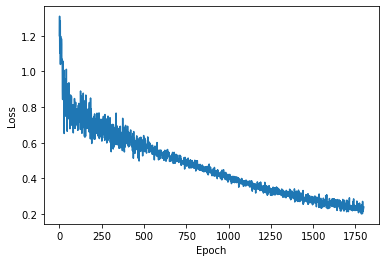

Test Accuracy: 0.9333


In [ ]:
# Iris Hyperparameters 2
learning_rate = 0.01
num_epochs = 1800
hidden_ly = [64,32,16]
n_hidden1 = 64
n_hidden2 = 32
n_hidden3 = 16
batch_size= 32
momentum = 0.5
n_output=3
print(f"learning_rate = {learning_rate}, epochs={num_epochs}, hidden_ly={hidden_ly}, batch={batch_size}, momentum={momentum}")
nn = NeuralNetwork(train_data, test_data, n_input, n_output, hidden_ly)
nn.train(num_epochs, batch_size, momentum, learning_rate)
nn.evaluate()

# Breast Cancer Dataset


learning_rate = 0.01, epochs=1500, hidden_ly=[128, 64, 32], batch=32, momentum=0.5
Epoch 0, loss: 0.8581
Epoch 100, loss: 0.6512
Epoch 200, loss: 0.4726
Epoch 300, loss: 0.5793
Epoch 400, loss: 0.3126
Epoch 500, loss: 0.2275
Epoch 600, loss: 0.2604
Epoch 700, loss: 0.1549
Epoch 800, loss: 0.2283
Epoch 900, loss: 0.1702
Epoch 1000, loss: 0.0819
Epoch 1100, loss: 0.3392
Epoch 1200, loss: 0.1040
Epoch 1300, loss: 0.1751
Epoch 1400, loss: 0.0740
Epoch 1500: average loss = 0.2016640990937622


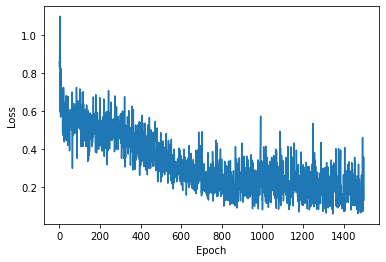

Test Accuracy: 0.9115


In [ ]:
breast_cancer = load_breast_cancer()
# Hyperparameters for breast_cancer 1
n_input = breast_cancer.data.shape[1]
learning_rate = 0.01
num_epochs = 1500
hidden_ly=[128,64,32]
batch_size = 32
momentum = 0.5
n_output=2

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(breast_cancer.data, breast_cancer.target, test_size=0.2)

# Create train and test datasets
train_data = load_breast_cancer()
train_data.data, train_data.target = X_train, y_train
test_data = load_breast_cancer()
test_data.data, test_data.target = X_test, y_test

print(f"learning_rate = {learning_rate}, epochs={num_epochs}, hidden_ly={hidden_ly}, batch={batch_size}, momentum={momentum}")
nn = NeuralNetwork(train_data, test_data, n_input, n_output, hidden_ly)
nn.train(num_epochs, batch_size, momentum, learning_rate)
nn.evaluate()

learning_rate = 0.01, epochs=1500, hidden_ly=[128, 64, 32], batch=32, momentum=0.5
Epoch 0, loss: 0.8160
Epoch 100, loss: 0.2637
Epoch 200, loss: 0.3170
Epoch 300, loss: 0.3451
Epoch 400, loss: 0.2174
Epoch 500, loss: 0.2772
Epoch 600, loss: 0.1864
Epoch 700, loss: 0.1319
Epoch 800, loss: 0.3055
Epoch 900, loss: 0.2794
Epoch 1000, loss: 0.2592
Epoch 1100, loss: 0.0718
Epoch 1200, loss: 0.2715
Epoch 1300, loss: 0.2153
Epoch 1400, loss: 0.2629
Epoch 1500: average loss = 0.2174404305574246


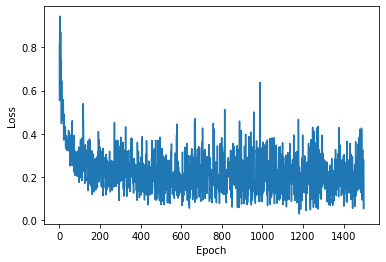

Test Accuracy: 0.9469


In [ ]:
# Hyperparameters for breast_cancer 2
n_input = breast_cancer.data.shape[1]
learning_rate = 0.01
num_epochs =1500
hidden_ly= [128,64,32]
batch_size = 32
momentum = 0.5
n_output=2
print(f"learning_rate = {learning_rate}, epochs={num_epochs}, hidden_ly={hidden_ly}, batch={batch_size}, momentum={momentum}")
nn1 = NeuralNetwork(train_data, test_data, n_input, n_output, hidden_ly)
nn1.train(num_epochs, batch_size, momentum, learning_rate)
nn1.evaluate()

learning_rate = 0.001, epochs=2500, hidden_ly=[256, 128, 64], batch=32, momentum=0.5
Epoch 0, loss: 1.7671
Epoch 100, loss: 2.0456
Epoch 200, loss: 1.5514
Epoch 300, loss: 1.4552
Epoch 400, loss: 1.0415
Epoch 500, loss: 1.5195
Epoch 600, loss: 1.9839
Epoch 700, loss: 1.1305
Epoch 800, loss: 0.7912
Epoch 900, loss: 1.4511
Epoch 1000, loss: 1.3052
Epoch 1100, loss: 0.8273
Epoch 1200, loss: 1.1406
Epoch 1300, loss: 1.4405
Epoch 1400, loss: 1.6281
Epoch 1500, loss: 1.9465
Epoch 1600, loss: 1.2610
Epoch 1700, loss: 1.0747
Epoch 1800, loss: 1.0916
Epoch 1900, loss: 1.3833
Epoch 2000, loss: 1.4460
Epoch 2100, loss: 1.0701
Epoch 2200, loss: 1.7924
Epoch 2300, loss: 1.1005
Epoch 2400, loss: 1.0145
Epoch 2500: average loss = 1.1733207691257388


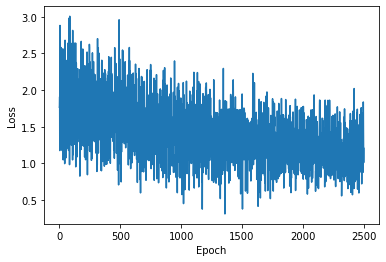

Test Accuracy: 0.5487


In [ ]:
# Hyperparameters for breast_cancer 3
n_input = breast_cancer.data.shape[1]
learning_rate = 0.001
num_epochs = 2500
hidden_ly=[256,128,64]
batch_size = 32
momentum = 0.5
n_output=2
print(f"learning_rate = {learning_rate}, epochs={num_epochs}, hidden_ly={hidden_ly}, batch={batch_size}, momentum={momentum}")
nn1 = NeuralNetwork(train_data, test_data, n_input, n_output, hidden_ly)
nn1.train(num_epochs, batch_size, momentum, learning_rate)
nn1.evaluate()

learning_rate = 0.001, epochs=3000, hidden_ly=[128, 64, 64], batch=32, momentum=0.5
Epoch 0, loss: 3.0617
Epoch 100, loss: 0.5387
Epoch 200, loss: 0.2592
Epoch 300, loss: 0.2170
Epoch 400, loss: 0.3545
Epoch 500, loss: 0.3451
Epoch 600, loss: 0.5253
Epoch 700, loss: 0.3113
Epoch 800, loss: 0.1884
Epoch 900, loss: 0.2720
Epoch 1000, loss: 0.3078
Epoch 1100, loss: 0.3335
Epoch 1200, loss: 0.2588
Epoch 1300, loss: 0.2013
Epoch 1400, loss: 0.1532
Epoch 1500, loss: 0.1733
Epoch 1600, loss: 0.1384
Epoch 1700, loss: 0.2813
Epoch 1800, loss: 0.2071
Epoch 1900, loss: 0.4129
Epoch 2000, loss: 0.2695
Epoch 2100, loss: 0.1833
Epoch 2200, loss: 0.4770
Epoch 2300, loss: 0.1320
Epoch 2400, loss: 0.2947
Epoch 2500, loss: 0.3190
Epoch 2600, loss: 0.1848
Epoch 2700, loss: 0.2279
Epoch 2800, loss: 0.2395
Epoch 2900, loss: 0.0765
Epoch 3000: average loss = 0.21332140408523342


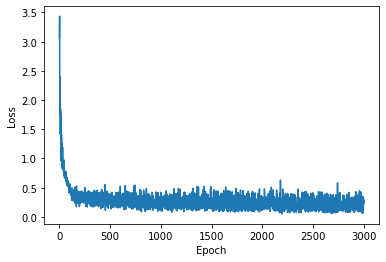

Test Accuracy: 0.9204


In [ ]:
# Hyperparameters for breast_cancer 4
n_input = breast_cancer.data.shape[1]
learning_rate = 0.001
num_epochs = 3000
hidden_ly=[128,64,64]
batch_size = 32
momentum = 0.5
n_output=2
print(f"learning_rate = {learning_rate}, epochs={num_epochs}, hidden_ly={hidden_ly}, batch={batch_size}, momentum={momentum}")
nn1 = NeuralNetwork(train_data, test_data, n_input, n_output, hidden_ly)
nn1.train(num_epochs, batch_size, momentum, learning_rate)
nn1.evaluate()

# Wine Dataset

In [ ]:
# Load the load_wine dataset
wine = load_wine()
n_input = wine.data.shape[1]
# Hyperparameters for wine dataset 1
learning_rate = 0.01
num_epochs = 2500
hidden_ly = [256,128,64,32]
batch_size = 32
momentum = 0.9
n_output = 3

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.2)

# Create train and test datasets
train_data = load_wine()
train_data.data, train_data.target = X_train, y_train
test_data = load_wine()
test_data.data, test_data.target = X_test, y_test

print(f"learning_rate = {learning_rate}, epochs={num_epochs}, hidden_ly={hidden_ly}, batch={batch_size}, momentum={momentum}")
nn2 = NeuralNetwork(train_data, test_data, n_input, n_output, hidden_ly)
nn2.train(num_epochs, batch_size, momentum, learning_rate)
nn2.evaluate()

learning_rate = 0.01, epochs=2500, hidden_ly=[256, 128, 64, 32], batch=32, momentum=0.9


NameError: name 'init_param' is not defined

learning_rate = 0.001, epochs=2500, hidden_ly=[512, 256, 128, 64, 32, 16], batch=32, momentum=0.3
Epoch 0, loss: 0.9216
Epoch 100, loss: 0.5752
Epoch 200, loss: 0.5091
Epoch 300, loss: 0.4615
Epoch 400, loss: 0.4663
Epoch 500, loss: 0.4182
Epoch 600, loss: 0.4260
Epoch 700, loss: 0.3547
Epoch 800, loss: 0.3612
Epoch 900, loss: 0.3748
Epoch 1000, loss: 0.4401
Epoch 1100, loss: 0.3884
Epoch 1200, loss: 0.4081
Epoch 1300, loss: 0.4276
Epoch 1400, loss: 0.3707
Epoch 1500, loss: 0.3034
Epoch 1600, loss: 0.3575
Epoch 1700, loss: 0.3616
Epoch 1800, loss: 0.3428
Epoch 1900, loss: 0.2972
Epoch 2000, loss: 0.2844
Epoch 2100, loss: 0.2840
Epoch 2200, loss: 0.3328
Epoch 2300, loss: 0.3386
Epoch 2400, loss: 0.3007
Epoch 2500: average loss = 0.30332858303897514


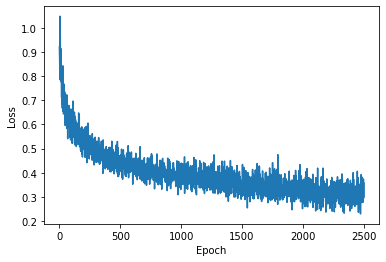

Test Accuracy: 0.7714


In [ ]:
# Hyperparameters for wine dataset 2
n_input = wine.data.shape[1]
learning_rate = 0.001
num_epochs = 2500
hidden_ly = [512,256,128,64,32,16]
batch_size = 32
momentum = 0.3
n_output = 3
print(f"learning_rate = {learning_rate}, epochs={num_epochs}, hidden_ly={hidden_ly}, batch={batch_size}, momentum={momentum}")
nn2 = NeuralNetwork(train_data, test_data, n_input, n_output, hidden_ly)
nn2.train(num_epochs, batch_size, momentum, learning_rate)
nn2.evaluate()

In [ ]:
# Hyperparameters for wine dataset 3
n_input = wine.data.shape[1]
learning_rate = 0.01
num_epochs = 2500
hidden_ly = [256,128,64]
batch_size = 32
momentum = 0.2
n_output = 3
print(f"learning_rate = {learning_rate}, epochs={num_epochs}, hidden_ly={hidden_ly}, batch={batch_size}, momentum={momentum}")
nn2 = NeuralNetwork(train_data, test_data, n_input, n_output, hidden_ly)
nn2.train(num_epochs, batch_size, momentum, learning_rate)
nn2.evaluate()

NameError: name 'wine' is not defined

learning_rate = 0.01, epochs=2500, hidden_ly=[256, 128, 32], batch=32, momentum=0.5
Epoch 0, loss: 1.1595
Epoch 100, loss: 0.4055
Epoch 200, loss: 0.3649
Epoch 300, loss: 0.3920
Epoch 400, loss: 0.3908
Epoch 500, loss: 0.4386
Epoch 600, loss: 0.3437
Epoch 700, loss: 0.4043
Epoch 800, loss: 0.3575
Epoch 900, loss: 0.4194
Epoch 1000, loss: 0.3997
Epoch 1100, loss: 0.3451
Epoch 1200, loss: 0.4397
Epoch 1300, loss: 0.3875
Epoch 1400, loss: 0.3586
Epoch 1500, loss: 0.3792
Epoch 1600, loss: 0.3220
Epoch 1700, loss: 0.4440
Epoch 1800, loss: 0.3843
Epoch 1900, loss: 0.3765
Epoch 2000, loss: 0.3528
Epoch 2100, loss: 0.3735
Epoch 2200, loss: 0.3381
Epoch 2300, loss: 0.4049
Epoch 2400, loss: 0.3238
Epoch 2500: average loss = 0.35698219017693444


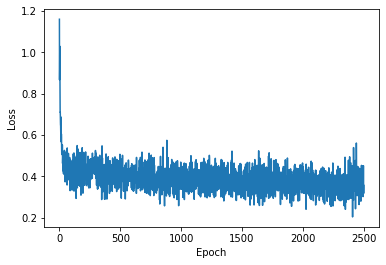

Test Accuracy: 0.7429


In [ ]:
# Hyperparameters for wine dataset 4
n_input = wine.data.shape[1]
learning_rate = 0.01
num_epochs = 2500
hidden_ly = [256,128,32]
batch_size = 32
momentum = 0.5
n_output = 3
print(f"learning_rate = {learning_rate}, epochs={num_epochs}, hidden_ly={hidden_ly}, batch={batch_size}, momentum={momentum}")
nn2 = NeuralNetwork(train_data, test_data, n_input, n_output, hidden_ly)
nn2.train(num_epochs, batch_size, momentum, learning_rate)
nn2.evaluate()

learning_rate = 0.01, epochs=2500, hidden_ly=[256, 128, 32], batch=32, momentum=0.5
Epoch 0, loss: 0.6162
Epoch 100, loss: 0.3453
Epoch 200, loss: 0.3480
Epoch 300, loss: 0.4763
Epoch 400, loss: 0.2984
Epoch 500, loss: 0.3219
Epoch 600, loss: 0.3472
Epoch 700, loss: 0.2765
Epoch 800, loss: 0.2354
Epoch 900, loss: 0.3869
Epoch 1000, loss: 0.3393
Epoch 1100, loss: 0.3330
Epoch 1200, loss: 0.2683
Epoch 1300, loss: 0.3077
Epoch 1400, loss: 0.3854
Epoch 1500, loss: 0.3863
Epoch 1600, loss: 0.3072
Epoch 1700, loss: 0.3048
Epoch 1800, loss: 0.3104
Epoch 1900, loss: 0.3911
Epoch 2000, loss: 0.2783
Epoch 2100, loss: 0.3776
Epoch 2200, loss: 0.3360
Epoch 2300, loss: 0.2717
Epoch 2400, loss: 0.3571
Epoch 2500: average loss = 0.35971508386910317


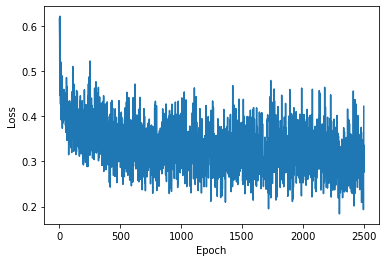

Test Accuracy: 0.8000


In [ ]:
# Hyperparameters for wine dataset 5
n_input = wine.data.shape[1]
learning_rate = 0.01
num_epochs = 2500
hidden_ly = [256,128,32]
batch_size = 32
momentum = 0.5
n_output=3
print(f"learning_rate = {learning_rate}, epochs={num_epochs}, hidden_ly={hidden_ly}, batch={batch_size}, momentum={momentum}")
nn2 = NeuralNetwork(train_data, test_data, n_input, n_output, hidden_ly)
nn2.train(num_epochs, batch_size, momentum, learning_rate)
nn2.evaluate()